In [3]:
import astropy.io.fits as fits
import csv
import copy
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import saphires as saph
from astropy import units as u
from astropy.coordinates import Angle
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.nddata import NDData, CCDData
from astropy.stats import gaussian_sigma_to_fwhm, sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time
from astropy.visualization import simple_norm, ZScaleInterval, SqrtStretch, ImageNormalize
from astropy.wcs import WCS
from astroquery.astrometry_net import AstrometryNet
from barycorrpy import utc_tdb
from barycorrpy import get_BC_vel
from ccdproc import Combiner
from matplotlib.backends.backend_pdf import PdfPages
from photutils import aperture_photometry, CircularAperture, EPSFBuilder, CircularAnnulus
from photutils.background import MMMBackground
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IterativelySubtractedPSFPhotometry, DAOGroup, extract_stars
from scipy.optimize import curve_fit
matplotlib.rcParams.update({'font.size': 12})
%matplotlib inline
ra = 73.59863195295
dec = +17.16480415593
pmra = -2.222
pmdec = -12.554
plx  = 6.9628
epoch = 2016.0

In [4]:
def import_images(im_list, p):
    '''
    A function that imports the data from an image file, following a given
    path to find the image file
    
        Paramters
        ---------
        im_list: list
            List containing the names of the image files
        p: string
            The pathway the script should follow to find the image
            files on the computer

        Returns
        -------
        im_data: list
            A list of the data arrays containing the pixel data
            of images
        in_headers: list
            A list of all the image headers
    '''
    im_data = []
    im_headers = []
    for i in im_list:
        path = p + i
        hdu = fits.open(path)
        data = hdu[1].data
        header = hdu[1].header
        im_data.append(data)
        im_headers.append(header)
    
    return im_data, im_headers

def find_stars(image, sigma, peak=100000):
    '''
    Searches data from an image to find objects above a given brightness
    threshold based off parameters of the ccd chip
        
        Parameters
        ----------
        image: array-like
            Array containing the intensity of light for each pixel
            on the ccd chip
        sigma: float
            sets the size tolerance for detected objects. Usually
            5.0, more than 5 is statistically unreasonable
        peak: int
            The max number of counts the chip can handle before the 
            image starts to smear. Usual ccd can handle 100,000 counts
            
        Returns
        -------
        stars: table
            A table containing all the found stars and their parameters:
            id, xcentroid, ycentroid, sharpness, roundness, npix, sky,
            peak, flux, mag
    '''
    sigma_psf = sigma
    mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
    bkg = median_val
    daofind = DAOStarFinder(fwhm=sigma_psf*gaussian_sigma_to_fwhm, threshold=bkg+20*std_val, sky=bkg, peakmax=peak, exclude_border=True)
    stars = daofind(image)
    return stars

def find_fwhm(image, size=100):
    mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
    max_peak = np.max(image)
    while max_peak >= 0:
        r, c = np.where(image==max_peak)[0][0], np.where(image==max_peak)[1][0]
        star = image[r-size:r+size,c-size:c+size]
        x = np.arange(2*size)
        y = np.arange(2*size)
        X, Y = np.meshgrid(x, y)
        def gaussian(M, x0, y0, sig_x, sig_y, A, off):
            x, y = M
            return A * exp(-((x-x0)**2)/(2*sig_x**2)-((y-y0)**2)/(2*sig_y**2)) + off
        xdata = np.vstack((X.ravel(), Y.ravel()))
        ydata = star.ravel()
        p = [size, size, 1, 1, 1, median_val]
        popt, pcov = curve_fit(f=gaussian, xdata=xdata, ydata=ydata, p0=p)
        im_sig = np.mean(popt[2:4])
        fwhm = im_sig*gaussian_sigma_to_fwhm
        if max_peak < 50000 and fwhm > 2:
            break
        image[r-size:r+size,c-size:c+size] = 0
        max_peak = np.max(image)
    
    return fwhm



9.885746002197266


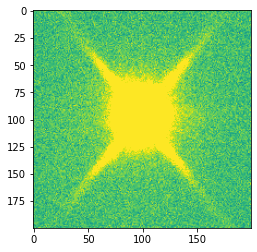

59262.35


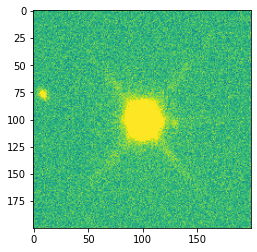

13433.004


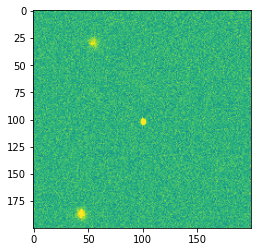

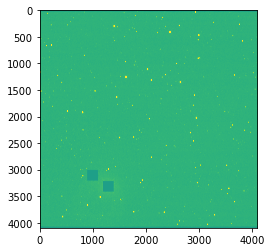

In [13]:
filenames, epochid = np.loadtxt('../Epochs_V.csv', unpack=True, delimiter=',', usecols=(0,1), dtype='U100,f')
nepochs = np.int(np.max(epochid))
images = filenames[(epochid == 92)]
path = '../fits/'
im_data, im_headers = import_images(im_list=images, p=path)
image = im_data[0]
norm = ImageNormalize(image, interval=ZScaleInterval(), stretch=SqrtStretch())
im = copy.deepcopy(image)
mean_val, median_val, std_val = sigma_clipped_stats(im, sigma=2.0)
print(median_val)
# im -= median_val
max_peak = np.max(im)
while max_peak >= 50000:
    r, c = np.where(im==max_peak)[0][0], np.where(im==max_peak)[1][0]
    size = 100
    star = im[r-size:r+size,c-size:c+size]
    plt.imshow(star, norm=norm)
    plt.show()
    im[r-size:r+size,c-size:c+size] = 0
    max_peak = np.max(im)
    print(max_peak)
r, c = np.where(im==max_peak)[0][0], np.where(im==max_peak)[1][0]
size = 100
star = im[r-size:r+size,c-size:c+size]
plt.imshow(star, norm=norm)
plt.show()
plt.imshow(im, norm=norm)
plt.show()

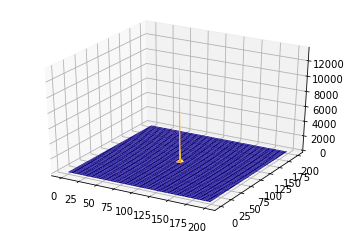

[ 25.35702871 100.75750892  23.64069877 -41.10762416  -1.8858358
  11.27237403]
[ 1.00187321e+02  1.00208398e+02 -3.65038621e-01  4.29801078e-01
  1.71423977e+04  1.05758469e+01]
0.03238122850574726
0.07625196596806123


In [14]:
from scipy.optimize import curve_fit

x = np.arange(200)
y = np.arange(200)
X, Y = np.meshgrid(x, y)
Z = star

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

def gaussian(M, x0, y0, sig_x, sig_y, A, off):
    x, y = M
    return A * np.exp(-((x-x0)**2)/(2*sig_x**2)-((y-y0)**2)/(2*sig_y**2)) + off

xdata = np.vstack((X.ravel(), Y.ravel()))
ydata = Z.ravel()

popt, pcov = curve_fit(f=gaussian, xdata=xdata, ydata=ydata)
print(popt)
p = [100, 100, 3, 3, 10000, median_val]
popt, pcov = curve_fit(f=gaussian, xdata=xdata, ydata=ydata, p0=p)
print(popt)
im_sig = np.mean(popt[2:4])
print(im_sig)
fwhm = im_sig*gaussian_sigma_to_fwhm
print(fwhm)

50121.113


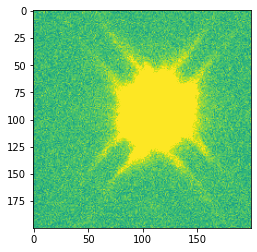

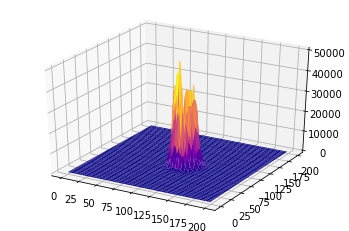

34.131607839739765
7639.0728


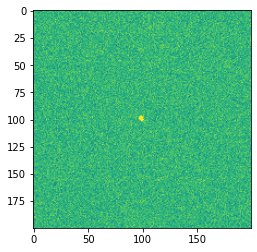

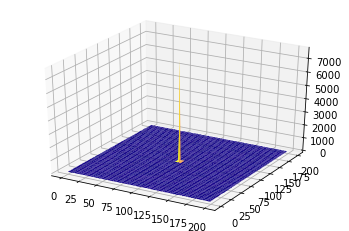

0.887060490896525
7069.774


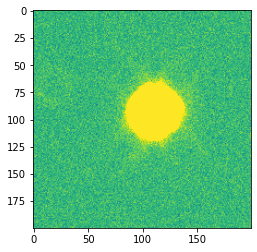

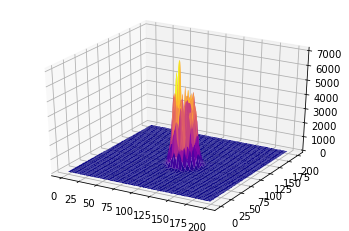

33.7427475682259
33.7427475682259


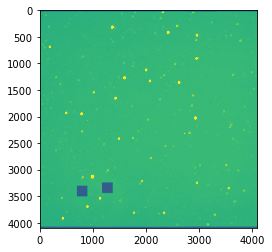

In [7]:
def find_fwhm(image, size=100):
    mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
    max_peak = np.max(image)
    while max_peak >= 0:
        r, c = np.where(image==max_peak)[0][0], np.where(image==max_peak)[1][0]
        star = image[r-size:r+size,c-size:c+size]
        print(max_peak)
        plt.imshow(star, norm=norm)
        plt.show()
        x = np.arange(2*size)
        y = np.arange(2*size)
        X, Y = np.meshgrid(x, y)
        def gaussian(M, x0, y0, sig_x, sig_y, A, off):
            x, y = M
            return A * np.exp(-((x-x0)**2)/(2*sig_x**2)-((y-y0)**2)/(2*sig_y**2)) + off
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(X, Y, star, cmap='plasma')
        ax.set_zlim(0,np.max(star)+2)
        plt.show()
        xdata = np.vstack((X.ravel(), Y.ravel()))
        ydata = star.ravel()
        p = [size, size, 3, 3, 10000, median_val]
        popt, pcov = curve_fit(f=gaussian, xdata=xdata, ydata=ydata, p0=p)
        im_sig = np.mean(popt[2:4])
        fwhm = im_sig*gaussian_sigma_to_fwhm
        print(fwhm)
        if max_peak < 50000 and fwhm > 2:
            break
        image[r-size:r+size,c-size:c+size] = 0
        max_peak = np.max(image)
    
    return fwhm

filenames, epochid = np.loadtxt('../Epochs_V.csv', unpack=True, delimiter=',', usecols=(0,1), dtype='U100,f')
nepochs = np.int(np.max(epochid))
images = filenames[(epochid == 97)]
path = '../fits/'
im_data, im_headers = import_images(im_list=images, p=path)
image = im_data[0]
norm = ImageNormalize(image, interval=ZScaleInterval(), stretch=SqrtStretch())
im = copy.deepcopy(image)
fwhm = find_fwhm(image=im)
print(fwhm)
plt.imshow(im, norm=norm)
plt.show()

In [ ]:
def find_fwhm(image, size=100):
    mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
    max_peak = np.max(image)
    while max_peak >= 0:
        r, c = np.where(image==max_peak)[0][0], np.where(image==max_peak)[1][0]
        star = image[r-size:r+size,c-size:c+size]
        plt.imshow(star, norm=norm)
        plt.show()
        x = np.arange(2*size)
        y = np.arange(2*size)
        X, Y = np.meshgrid(x, y)
        def gaussian(M, x0, y0, sig_x, sig_y, A, off):
            x, y = M
            return A * np.exp(-((x-x0)**2)/(2*sig_x**2)-((y-y0)**2)/(2*sig_y**2)) + off
        xdata = np.vstack((X.ravel(), Y.ravel()))
        ydata = star.ravel()
        p = [size, size, 3, 3, 10000, median_val]
        popt, pcov = curve_fit(f=gaussian, xdata=xdata, ydata=ydata, p0=p)
        im_sig = np.mean(popt[2:4])
        fwhm = im_sig*gaussian_sigma_to_fwhm
        if max_peak < 50000 and fwhm > 2:
            break
        image[r-size:r+size,c-size:c+size] = 0
        max_peak = np.max(image)
    
    return fwhm

# Reworking image_combiner

#im_data, headers = import_images(im_list=images, p=p)

# def image_combiner(im_data, sigma):
#     stars = []
#     for i in im_data:
#         s = find_stars(image=i, sigma, peak=100000)
#         stars.append(s)
#     if s is None:
#         median_image = None
#         return median_image #, headers, im_data
#     else:
#         diffs = []
#         for s in range(len(stars)):
#                 diff = calculate_shift(stars1=stars[0], stars2=stars[s])
#                 diffs.append(diff)
#         images = []
#         for i in range(len(im_data)):
#             image_shift = roll_image(image=im_data[i], diff=diffs[i], threshold=0.5)
#             images.append(image_shift)
#         median_image = median_combiner(images=images)
        
#         return median_image #, headers, im_data